## Workshop on Fast Food Restaurant

by Kaylee Vo

*notebook is a work in progress most of this was done in class but is in the repo for reference.*

In [58]:
import numpy as np
import matplotlib.pyplot as plt

In [59]:
# Customize for matplotlib
# If interested in the matplotlib object hierarchy, check: https://realpython.com/python-matplotlib-guide/
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["mathtext.default"] = "regular"
# Change font size: http://www.futurile.net/2016/02/27/matplotlib-beautiful-plots-with-style/
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["figure.titlesize"] = 20

### Problem 1

**What are the relevant processes and data to collect?**

The relevant processes are ;
1. Customer Arrival: The number of customers arriving at the restaurant per unit time.
2. Service Time: The time taken to serve each customer.

The data to collect includes:
1. Profit and loss 
2. Arrival data in order to estimate the arrival rate and to determine the distribution of inter-arrival times.
3. Service time data to estimate the service rate and to determine the distribution of service times.

### Problem 2

**Suppose you know on average how often a customer comes, what kind of distribution would you assume for the customer arrival? What about the service time?**

As a first pass, the assumption we will make for the customer arrival is exponentially distributed. We'll also assume that the service time is exponentially distributed. These assumptions make the model analytically tractable but may not be realistic in practice, especially for service time. We may relax this assumption later.

### Problem 3

We shall assume the service time is exponentially distributed (please criticize this 
choice). Suppose you know the price of the food item (say a burger) and the cost 
(labor plus material) of producing it, and you have the policy that the customer will 
get the food for free if the wait time exceeds some threshold. Investigate whether 
that is a profitable policy by modifying the queuing.m code on canvas. Considering 
the following questions:

#### Part A

Let $a$ and $b$ be the average number of arrivals and customers served per 
unit time for a typical restaurant under consideration. **What is the expected total 
time (wait time plus the service time)?** In queuing theory, there is an analytical 
result that the probability that total time $T$ exceeds a value $t$ is given by 

$$
P(T > t) = e^{- (b - a) t}
$$
    
where $a$ and $b$ are the average number of arrivals and customers served per unit 
time. **Can you verify this result with the code `queuing.m` or `queuing.ipynb`?** 

In [60]:
a = 1  # average number of arrivals per minute
b = 1.5  # average number of people served per minute (reduce from 1.5 to 1.1 or 0.95)
ncust = 10000  # number of customers

In [61]:
# Make sure that a < b
assert a < b, "Average arrival rate must be less than average service rate."

From the class notes, "Derivation of Expected Total Time.pdf", we know the expected total time is given by:
$$
E[T] = \frac{1}{b - a}$$

where $a$ is the average arrival rate and $b$ is the average service rate. We'll compute it below to cross check with the simulation results.

In [62]:
# Expected total time

exp_total_time = 1 / (b - a)
print(f"E[T] = {exp_total_time:.3f} minutes")

E[T] = 2.000 minutes


Notation:

`at` = arrival time of a person joining the queue

`st` = service time once they reach the front

`ft` = finish time after waiting and being served

In [63]:
# Initialize arrays
at = np.zeros((ncust, 1))
ft = np.zeros((ncust, 1))
# Generate random arrival times assuming Poisson process:
r = np.random.uniform(low=0.0, high=1.0, size=(ncust, 1))
iat = -(1.0 / a) * np.log(r)  # generate inter-arrival times, exponential distribution
at[0] = iat[0]  # arrival time of first customer
for i in range(1, ncust):
    at[i] = at[i - 1] + iat[i]

# Generate random service times for each customer:
r = np.random.uniform(low=0.0, high=1.0, size=(ncust, 1))
st = -(1.0 / b) * np.log(
    r
)  # service time for each customer, follow an expoential distribution
# Compute time each customer finishes:
ft[0] = at[0] + st[0]
for i in range(1, ncust):
    # compute finish time for each customer as the larger of
    # arrival time plus service time (if no wait)
    # finish time of previous customer plus service time (if wait)
    ft[i] = np.maximum(at[i] + st[i], ft[i - 1] + st[i])

total_time = ft - at  # total time spent by each customer
wait_time = total_time - st  # time spent waiting before being served
ave_service_time = np.sum(st) / np.float32(ncust)
ave_wait_time = np.sum(wait_time) / np.float32(ncust)
ave_total_time = np.sum(total_time) / np.float32(ncust)
print("ave_service_time = ", ave_service_time)
print("ave_wait_time = ", ave_wait_time)
print("ave_total_time = ", ave_total_time)

ave_service_time =  0.6725763844575395
ave_wait_time =  1.315519483303336
ave_total_time =  1.9880958677608753


The expected total time derived analytically is close to the simulated result (roughly around 2). Now we'll plot the analytical result and the simulation results to compare them visually. In order to do this, we'll first differentiate the CDF.

$$
P(T \leq t ) = 1 - P(T > t) = 1 - e^{- (b - a) t}
$$

Differentiate:

$$
\frac{d}{dt} P(T \leq t) = (b - a) e^{- (b - a) t}
$$

This gives us the PMF of the total time $T$:

$$
P(T = t) = (b - a) e^{- (b - a) t}.
$$

    

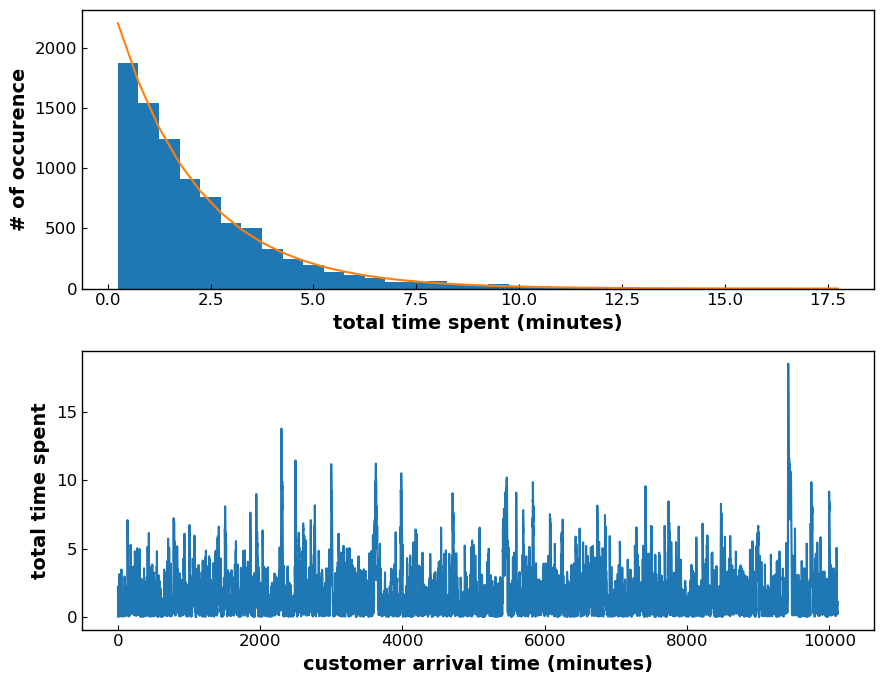

In [64]:
# Compare simulation to Poisson distribution
fig, axs = plt.subplots(2, 1, figsize=(9, 7), tight_layout=True)

bin_size = 0.5

# Plot histogram of waiting times
axs[0].hist(
    total_time, bins=np.arange(0.25, np.floor(np.max(total_time)) + 0.25, bin_size)
)
axs[0].set(ylabel="# of occurence")
axs[0].set(xlabel="total time spent (minutes)")

x = np.arange(0.25, np.floor(np.max(total_time)) + 0.25, bin_size)

# need to scale by bin_size * ncust to get the PMF
y = (b - a) * np.exp(-1 * (b - a) * x) * bin_size * ncust
axs[0].plot(x, y, label="PMF")

# Plot total time
axs[1].plot(at, total_time)
axs[1].set(xlabel="customer arrival time (minutes)")
axs[1].set(ylabel="total time spent")

plt.show()

### Part B

**How should we choose the guaranteed time? How should we model how the inter-arrival time of the customers changes with the guaranteed time (also known as a behavior response function)?**

The guaranteed time and the inter-arrival time of customers should inversely related to each other. If the guaranteed time is short, this means food is essentially free, therefore customers will arrive more frequently. If the guaranteed time is long, customers will arrive less frequently because it's less of a better deal for them.

### Part C

**After you have decided on a behavior response function, think about how you would get the expected profit given the guaranteed time.**

For the behavior response function, we'll use a logistic curve. We choose a logistic curve because it bounds the average number of arrivals per minute. We don't want $a$ to be too high, otherwise the condition of $a < b$ will not hold. The system will blow up. We'll choose the logistic curve to be bounded between (1.8, 0.8).

## Problem 4

### Part A

**Modify the code fastfood.m or fastfood.ipynb so that the inter-arrival time 
is a function of the time guarantee based on what you decided in part 3.**

In [151]:
def customer_response(time_guarantee):
    """
    Computes the average number of arrivals per minute given the time guarantee.
    Currently a placeholder returning a fixed value.

    Input: time_guarantee, If exceeded, no charge for the food
    Output: the average number of arrivals per minute given the time guarantee

    """
    # Logistic Curve
    average_arrivals_per_minute = 0.6 / (1 + np.exp(1 * (time_guarantee - 5))) + 0.8
    return average_arrivals_per_minute

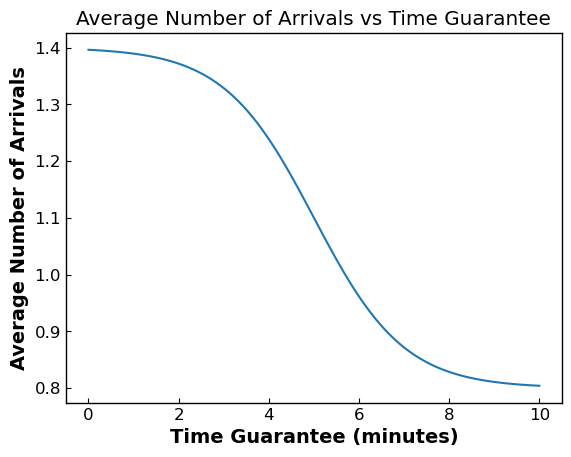

In [152]:
time_guarantee = np.linspace(0, 10, 100)

y = 0.6 / (1 + np.exp(1 * (time_guarantee - 5))) + 0.8

plt.plot(time_guarantee, y)
plt.xlabel("Time Guarantee (minutes)")
plt.ylabel("Average Number of Arrivals")
plt.title("Average Number of Arrivals vs Time Guarantee")
plt.show()

### Part B

**Knowing the cost and profit, plot the profit per unit time as a function of the time guarantee and find the maximum. Remember this is a stochastic system so you need to run many experiments/trials to draw useful conclusions.**

In [153]:
def compute_profit(time_guarantee, total_time, profit_margin):
    """
    Computes profit (normalized by cost) per minute.
    """
    profit = 0
    for time in total_time:
        if time < time_guarantee:
            profit += profit_margin  # Making a profit
        else:
            profit -= 1  # Giving out free food
    return profit

In [154]:
def queuing_simulation(a, b, ncust):
    """
    Simulates an M/M/1 queue.

    Inputs:
       a: average number of arrivals per minute
       b: average number of people served per minute (reduce from 1.5 to 1.1 or 0.95)
       ncust: number of customers to simulate
    Outputs:
       at = arrival time of a person joining the queue
       st = service time once they reach the front
       ft = finish time after waiting and being served.
    """
    # Generate random inter-arrival times assuming a Poisson process
    iat = -1 / a * np.log(np.random.rand(ncust))
    at = np.cumsum(iat)  # Arrival times

    # Generate random service times assuming an exponential distribution
    st = -1 / b * np.log(np.random.rand(ncust))

    # Compute finish times
    ft = np.zeros(ncust)
    ft[0] = at[0] + st[0]  # First customer's finish time

    # compute finish time for each customer as the larger of
    # arrival time plus service time (if no wait)
    # finish time of previous customer plus service time (if wait)
    for i in range(1, ncust):
        ft[i] = max(at[i] + st[i], ft[i - 1] + st[i])

    return at, ft, st

Notation:

`at` = arrival time of a person joining the queue

`st` = service time once they reach the front

`ft` = finish time after waiting and being served

In [155]:
a = 1  # Average number of arrivals per minute
b = 1.6  # Average number of people served per minute
ncust = 10000  # Number of customers

profit_margin = 0.7  # (price - cost) / cost
time_guarantee = 20  # Guaranteed time

# Compute the average number of arrivals per minute given the time guarantee
a = customer_response(time_guarantee)

# Run the queuing simulation
at, ft, st = queuing_simulation(a, b, ncust)

# Total time spent by each customer
total_time = ft - at
wait_time = total_time - st  # time spent waiting before being served

# Compute total profit (normalized by cost)
profit = compute_profit(time_guarantee, total_time, profit_margin)

# Compute profit per minute
profit_per_minute = profit / ft[-1]
print(f"Profit per minute: {profit_per_minute}")
ave_service_time = np.sum(st) / np.float32(ncust)
ave_wait_time = np.sum(wait_time) / np.float32(ncust)
ave_total_time = np.sum(total_time) / np.float32(ncust)
print("ave_service_time = ", ave_service_time)
print("ave_wait_time = ", ave_wait_time)
print("ave_total_time = ", ave_total_time)

Profit per minute: 0.5694307435322905
ave_service_time =  0.6246352259574341
ave_wait_time =  0.66762563348466
ave_total_time =  1.2922608594420941


In [156]:
def get_profit(time_guarantee):
    a = 1  # Average number of arrivals per minute
    b = 1.6  # Average number of people served per minute
    ncust = 10000  # Number of customers

    profit_margin = 0.7  # (price - cost) / cost

    # Compute the average number of arrivals per minute given the time guarantee
    a = customer_response(time_guarantee)

    # Run the queuing simulation
    at, ft, st = queuing_simulation(a, b, ncust)

    # Total time spent by each customer
    total_time = ft - at

    # Compute total profit (normalized by cost)
    profit = compute_profit(time_guarantee, total_time, profit_margin)

    # We divide by the last finish time to normalize profit per minute
    return profit / ft[-1]

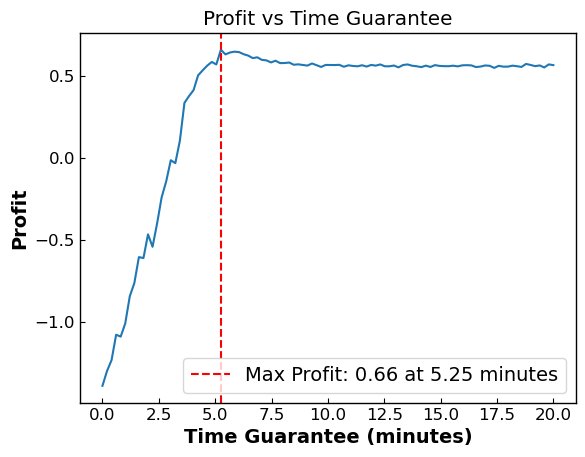

In [157]:
time_guarantees = np.linspace(0, 20, 100)
profits = [get_profit(t) for t in time_guarantees]

# Get the maximum profit and the corresponding time guarantee
max_profit = np.max(profits)
max_profit_time = time_guarantees[np.argmax(profits)]

plt.plot(time_guarantees, profits)
plt.axvline(
    max_profit_time,
    color="red",
    linestyle="--",
    label=f"Max Profit: {max_profit:.2f} at {max_profit_time:.2f} minutes",
)
plt.xlabel("Time Guarantee (minutes)")
plt.ylabel("Profit")
plt.title("Profit vs Time Guarantee")
plt.legend()
plt.show()

- Profit is profit per minute

### Part C

**Modify the service time to see how much faster the kitchen needs to be compared the industry standard for the policy to increase profit. Note that guarantee is designed to increase the number of arrivals per unit time and will further require faster service.**

In [163]:
best_time_guarantee = time_guarantees[np.argmax(profits)]

In [164]:
def get_profit(time_guarantee, b):
    a = 1  # Average number of arrivals per minute
    # b = 1.6  # Average number of people served per minute
    ncust = 10000  # Number of customers

    profit_margin = 0.7  # (price - cost) / cost

    # Compute the average number of arrivals per minute given the time guarantee
    a = customer_response(time_guarantee)

    # Run the queuing simulation
    at, ft, st = queuing_simulation(a, b, ncust)

    # Total time spent by each customer
    total_time = ft - at

    # Compute total profit (normalized by cost)
    profit = compute_profit(time_guarantee, total_time, profit_margin)

    # We divide by the last finish time to normalize profit per minute
    return profit / ft[-1]

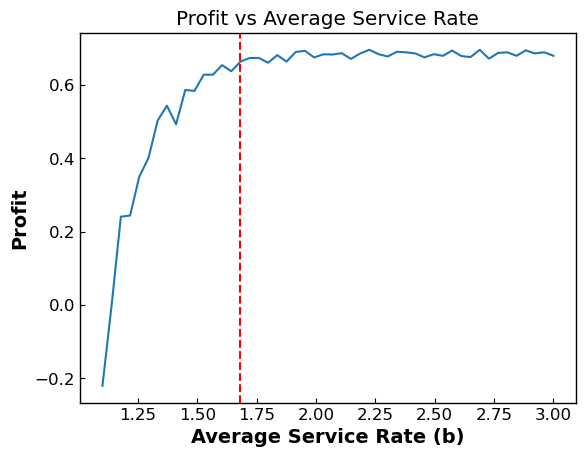

In [166]:
b_vals = np.linspace(1.1, 3.0, 50)  # Range of b values to test
profits = [get_profit(best_time_guarantee, b) for b in b_vals]

# get first service time that gives a profit greater than the max profit
best_b = None
for b, profit in zip(b_vals, profits):
    if profit > max_profit:
        best_b = b
        break

plt.plot(b_vals, profits)
plt.xlabel("Average Service Rate (b)")
plt.ylabel("Profit")
plt.title("Profit vs Average Service Rate")
plt.axvline(
    best_b,
    color="red",
    linestyle="--",
    label=f"Best b: {best_b:.2f} for max profit > {max_profit:.2f}",
)
plt.show()

In [167]:
best_b

1.6816326530612247

We set the time guarantee to the prior value that we found to be best. Now we vary the service time and find the service time for which profit increases beyond the prior part. Here we find any value greater than 1.68 will increase profits from the prior example.

#### Part D

**Explore the dependence of your conclusions on the profit margin and the industry standard inter-arrival and service time.**

To explore the parameter dependencies of our conclusions, we'll plot the contour of profit with three sets of parameters
1. $(\text{profit margin}, a)$
2. $(\text{profit margin}, b)$
3. $(a, b)$

##### i. Contour Plot with $(\text{profit margin}, a)$

In [ ]:
def get_profit(time_guarantee, profit_margin, a, b):
    ncust = 10000  # Number of customers

    # profit_margin = 0.7  # (price - cost) / cost

    # Compute the average number of arrivals per minute given the time guarantee
    a = customer_response(time_guarantee)

    # Run the queuing simulation
    at, ft, st = queuing_simulation(a, b, ncust)

    # Total time spent by each customer
    total_time = ft - at

    # Compute total profit (normalized by cost)
    profit = compute_profit(time_guarantee, total_time, profit_margin)

    # We divide by the last finish time to normalize profit per minute
    return profit / ft[-1]


# Define grid over profit_margin and arrival rate a
profit_margins = np.linspace(0.1, 1.0, 50)
a_vals = np.linspace(0.5, 2.0, 50)
b = 2.0  # Fixed
time_guarantee = 5.0  # Fixed

# Compute profit for each combination
Z = np.zeros((len(a_vals), len(profit_margins)))

for i, a in enumerate(a_vals):
    for j, pm in enumerate(profit_margins):
        Z[i, j] = get_profit(time_guarantee, pm, a, b)

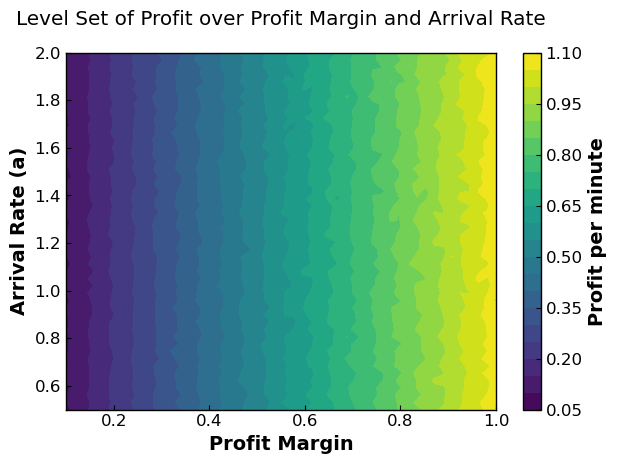

In [174]:
# Plot level set
X, Y = np.meshgrid(profit_margins, a_vals)
plt.contourf(X, Y, Z, levels=20, cmap="viridis")
plt.colorbar(label="Profit per minute")
plt.xlabel("Profit Margin")
plt.ylabel("Arrival Rate (a)")
plt.title("Level Set of Profit over Profit Margin and Arrival Rate", pad=20)
plt.tight_layout()
plt.show()

- The contour plot shows that profit increases with profit margin but it seems that arrival rate doesn't make a bit difference.
- Note we fix `time_guarantee=5` and $b=2.0$.

##### ii. Contour Plot with $(\text{profit margin}, b)$

In [180]:
# Define grid over profit_margin and arrival rate a
profit_margins = np.linspace(0.1, 1.0, 50)
a = 1.0  # Fixed
b_vals = np.linspace(1.1, 3.0, 50)  # Range of b values to test
time_guarantee = 5.0  # Fixed

# Compute profit for each combination
Z = np.zeros((len(b_vals), len(profit_margins)))

for i, b in enumerate(b_vals):
    for j, pm in enumerate(profit_margins):
        Z[i, j] = get_profit(time_guarantee, pm, a, b)

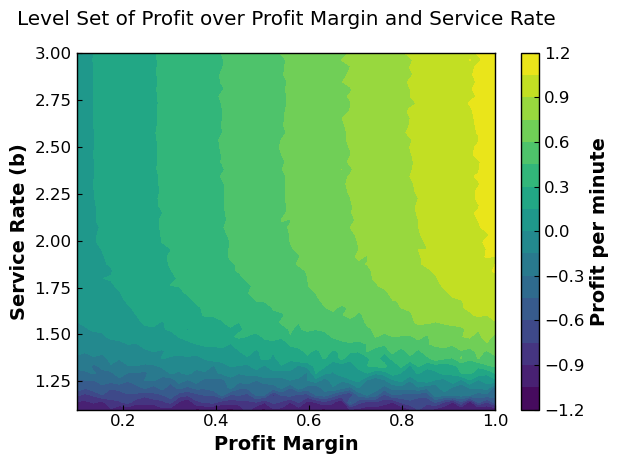

In [181]:
# Plot level set
X, Y = np.meshgrid(profit_margins, b_vals)
plt.contourf(X, Y, Z, levels=20, cmap="viridis")
plt.colorbar(label="Profit per minute")
plt.xlabel("Profit Margin")
plt.ylabel("Service Rate (b)")
plt.title("Level Set of Profit over Profit Margin and Service Rate", pad=20)
plt.tight_layout()
plt.show()

- Again, increasing the profit margin has a large impact on profit.
- We see that for a fixed profit margin, increasing the service rate $b$ increases profit but only up to a point. After a certain point, increasing $b$ does not significantly increase profit (stays on the same level set).

##### iii. Contour Plot with $(a, b)$

In [190]:
# Define grid over profit_margin and arrival rate a
profit_margin = 0.7  # Fixed
# Range was chosen because we want a < b
a_vals = np.linspace(0.5, 2.0, 20)  # Range of a values to test
b_vals = np.linspace(2.0, 4.0, 20)  # Range of b values to test
time_guarantee = 5.0  # Fixed

# Compute profit for each combination
Z = np.zeros((len(a_vals), len(b_vals)))

for i, a in enumerate(a_vals):
    for j, b in enumerate(b_vals):
        Z[i, j] = get_profit(time_guarantee, profit_margin, a, b)

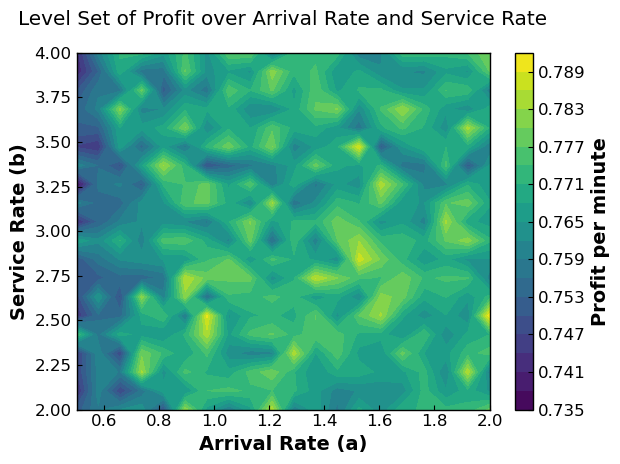

In [191]:
# Plot level set
X, Y = np.meshgrid(a_vals, b_vals)
plt.contourf(X, Y, Z, levels=20, cmap="viridis")
plt.colorbar(label="Profit per minute")
plt.xlabel("Arrival Rate (a)")
plt.ylabel("Service Rate (b)")
plt.title("Level Set of Profit over Arrival Rate and Service Rate", pad=20)
plt.tight_layout()
plt.show()

- The contour plots of profit with $(a, b)$ don't have a clear pattern to them. There are pockets of high profit but overall there isn't a clear combination of $a$ and $b$ that maximizes profit across the entire range.